epoch:10, loss:0.090
epoch:20, loss:0.060
epoch:30, loss:0.044
epoch:40, loss:0.034
epoch:50, loss:0.027
epoch:60, loss:0.021
epoch:70, loss:0.017
epoch:80, loss:0.015
epoch:90, loss:0.013
epoch:100, loss:0.012
epoch:110, loss:0.011
epoch:120, loss:0.011
epoch:130, loss:0.010
epoch:140, loss:0.010
epoch:150, loss:0.010
epoch:160, loss:0.010
epoch:170, loss:0.009
epoch:180, loss:0.009
epoch:190, loss:0.009
epoch:200, loss:0.009
epoch:210, loss:0.009
epoch:220, loss:0.009
epoch:230, loss:0.009
epoch:240, loss:0.009
epoch:250, loss:0.009
损失:0.009, 43273.7 tokens/秒 在 cuda:0上


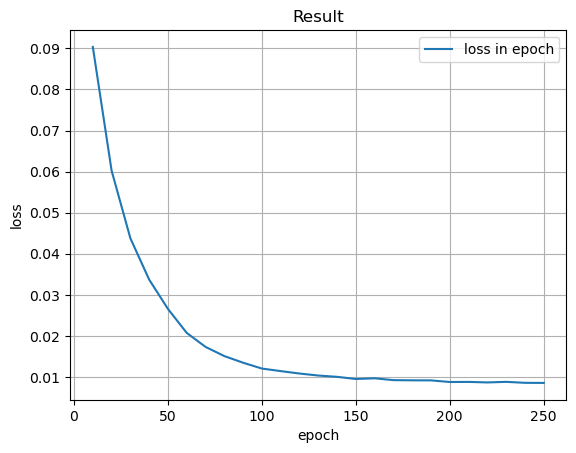

In [1]:
import torch, utils, nmt_utils, collections, math
from torch import nn

class AttentionDecoder(nn.Module):
    """带有注意力机制的解码器的基本接口"""
    def __init__(self, **kwargs):
        super().__init__()
    
class Seq2SeqAttentionDecoder(AttentionDecoder):
    """
    带有Bahdanau注意力的循环神经网络解码器
    此解码器中, 前一时间解码器的隐状态是查询
    编码器隐状态既是键, 也是值
    注意力权重使用加性注意力计算
    """
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        """
        attention初始化:
        1. 编码器在所有时间步的最终层隐状态，将作为注意力的键和值；
        2. 上一时间步的编码器全层隐状态，将作为初始化解码器的隐状态；
        3. 编码器有效长度（排除在注意力池中填充词元）。
        """
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size+num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.attention = utils.AdditiveAttention(num_hiddens, num_hiddens, num_hiddens, dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, encoder_outputs, encoder_valid_lens, *args):
        """
        返回解码器的初始隐状态\n
        在这个模型中, 解码器的状态是(输出, 隐状态, 编码器编码序列的有效长度)\n
        """
        # outputs的形状为(batch_size, num_steps, num_hiddens)
        # hidden_state的形状为(num_layers, batch_size, num_hiddens)
        outputs, hidden_state = encoder_outputs
        return (outputs.permute(1, 0, 2), hidden_state, encoder_valid_lens)

    def forward(self, X, state):
        encoder_outputs, hidden_state, encoder_valid_lens = state
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X: # x: 每个时间步的所有批量样本 shape=(batch_size, embed_dim)
            query = torch.unsqueeze(hidden_state[-1], dim=1) # shape = (batch_size, 1, num_hiddens)
            context = self.attention(query, encoder_outputs, encoder_outputs, encoder_valid_lens) # shape = (batch_size, 1, num_hiddens)
            x = torch.concat((context, torch.unsqueeze(x, dim=1)), dim=-1) # 在特征维度上连接上下文变量和x
            output, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state) # x要先变形为(1, batch_size, num_hiddens+embed_size)
            outputs.append(output)
            self._attention_weights.append(self.attention.attention_weights) # 每个时间步的注意力权重
        # 全连接层变换后, output的形状为(num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [encoder_outputs, hidden_state, encoder_valid_lens]
    
    @property
    def attention_weights(self):
        return self._attention_weights

embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, utils.try_gpu()
train_iter, src_vocab, tgt_vocab = nmt_utils.load_data_nmt(batch_size, num_steps)
encoder = utils.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = utils.EncoderDecoder(encoder, decoder)
utils.seq2seq_train(net, train_iter, lr, num_epochs, tgt_vocab, device)

go . => va ! bleu 1.000
i lost . => j'ai perdu . bleu 1.000
he's calm . => il est mouillé . bleu 0.658
i'm home . => je me suis malade . bleu 0.000


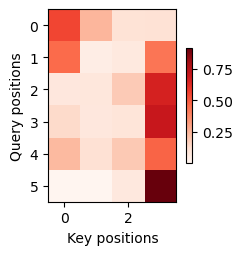

In [34]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, 
                    num_steps, device, save_attention_weights=False):
    """序列到序列模型的预测"""
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']] # 给src_tokens加上'<eos>'
    encoder_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = nmt_utils.truncate_pad(src_tokens, num_steps, src_vocab['<pad>']) # 对源词元进行截断和填充
    encoder_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0) # 添加批量轴
    encoder_outputs = net.encoder(encoder_X, encoder_valid_len)
    decoder_state = net.decoder.init_state(encoder_outputs, encoder_valid_len)
    decoder_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0) # 添加批量轴
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, decoder_state = net.decoder(decoder_X, decoder_state) # Y.shape=(1, 1, tgt_vocab_size)
        decoder_X = Y.argmax(dim=2) # 使用具有最高可能性的词元, 作为解码器在下一时间步的输入
        pred = decoder_X.squeeze(dim=0).type(torch.int32).item()
        if save_attention_weights: # 保存注意力权重
            attention_weight_seq.append(net.decoder.attention.attention_weights)
        if pred == tgt_vocab['<eos>']: # 一旦结束词元被预测,输出序列的生成就完成了
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

def bleu(pred_seq, label_seq, k):
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred)) # 初始惩罚项,用于降低较短序列(因为容易预测)的分数 公式的前半部分
    for n in range(1, min(k, len_pred)+1):
        num_matches, label_ngram_cnt = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1): # 初始化标签序列的n元语法表
            label_ngram_cnt[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1): # 查找预测序列中有多少和标签序列表匹配的n元语法
            if label_ngram_cnt[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_ngram_cnt[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n)) # p_n * 1/2^n 公式的后半部分
    return score

engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation} bleu {bleu(translation, fra, k=2):.3f}')
attention_weights = torch.cat([step[0][0] for step in dec_attention_weight_seq], dim=0).reshape((1, 1, -1, num_steps))
utils.show_heatmaps(attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
                    xlabel='Key positions', ylabel='Query positions')